In [21]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('corrected_data.csv', skipinitialspace=True, sep=',', index_col=0)

In [4]:
# здесь слишком много пропусков
df.drop('температура_воздуха_на_улице', axis=1, inplace=True)

In [15]:
# столбцы, которые могут влиять на температуру воздуха в помещении
factors = df[['время_года', 
         'климат', 
         'способ_охлаждения', 
         'режим_при_смешанном_типе_охлаждения', 
         'способ_обогрева', 
         'rh', 
         'скорость_воздуха', 
         'занавески', 
         'вентилятор', 
         'окно', 
         'двери', 
         'среднемесячная_температура_на_улице']]

In [11]:
# шкалы этих столбцов
types = {
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    'температура_воздуха_в_помещении': 'num', 
    'температура_воздуха_на_улице': 'num', 
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    'занавески': 'cat',
    'вентилятор': 'cat', 
    'окно': 'cat', 
    'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'
}

In [19]:
# функция, делающая график зависимости двух факторов на основе их типа
def get_plot(col1, col2, type1, type2, i, j):
    global ax
    # если разные шкалы - боксплот
    if type1 != type2:
        if type1 == 'cat':
            sns.boxplot(x=col1, y=col2, ax=ax[i, j])
        else:
            sns.boxplot(x=col2, y=col1, ax=ax[i, j])
    else: # иначе, т.к. одна из шкал - температура, то есть количественная, - скаттерплот
        sns.scatterplot(x=col1, y=col2, ax=ax[i, j], legend=False)

In [6]:
# применяем label encode к климату, так проще визуализировать на графике
unq = factors['климат'].unique()
enc = {unq[i]: i for i in range(len(unq))}
factors['климат'] = factors['климат'].apply(lambda x: enc[x])

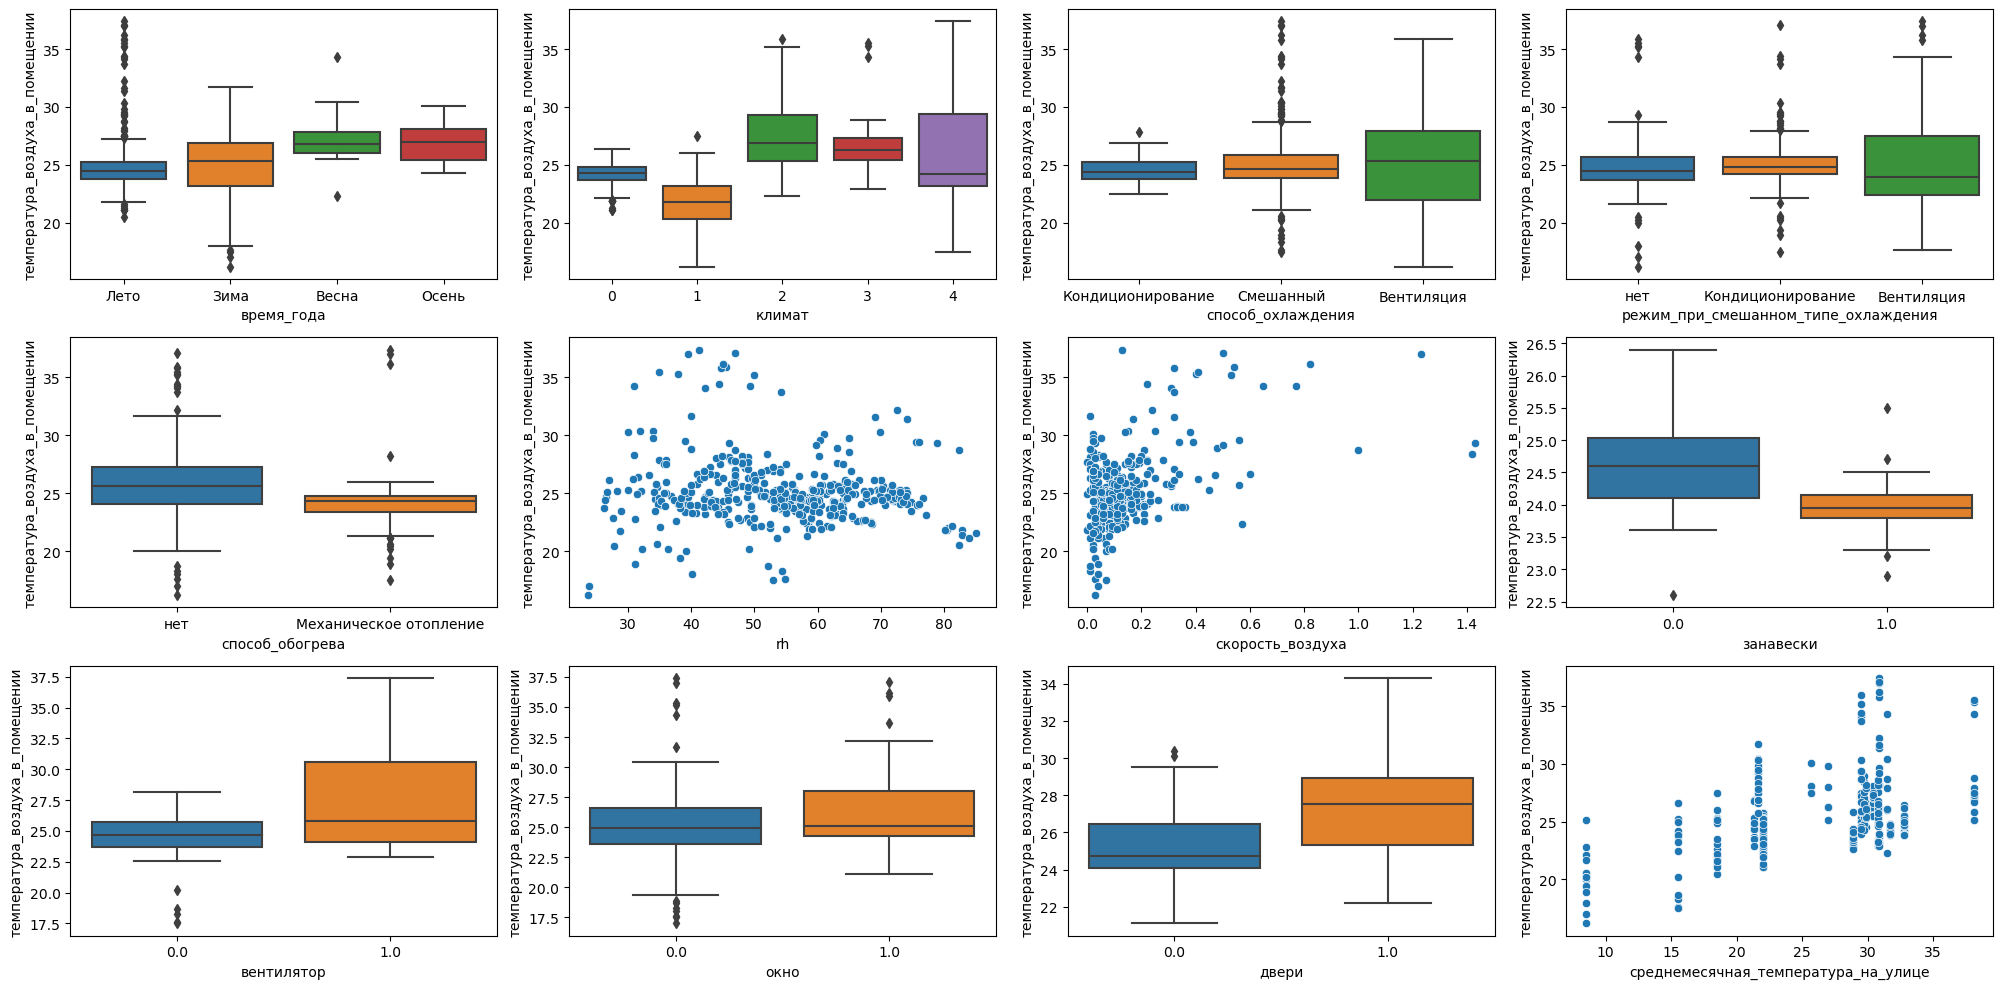

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
i = 0
for col in factors.columns:
    get_plot(df[col], df['температура_воздуха_в_помещении'], types[col], types['температура_воздуха_в_помещении'], i // 4, i % 4)
    i += 1
fig.tight_layout()

In [137]:
# выделяем те факторы, влияние которых наибольшее (визуально)
factors = df[['rh', 'занавески', 'вентилятор']]
target = df['температура_воздуха_в_помещении']

In [138]:
# применяем энкодинг к категориальным столбцам
for col in factors.columns:
    if factors[col].dtype not in ['float', 'int']:
        enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        factors[(col + ': ' + factors[col].unique()).tolist()] = enc.fit_transform(factors[[col]])
        factors.drop(col, axis=1, inplace=True)

In [139]:
x_train, x_test, y_train, y_test = train_test_split(factors, target, test_size=0.15, random_state=42)

In [ ]:
# строим модель и проверяем её эффективность
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

In [141]:
# сохраняем модель
from joblib import dump, load
dump(reg, 'regressor.joblib')

In [142]:
# загружаем модель
reg = load('regressor.joblib')

sklearn.linear_model._base.LinearRegression